In [1]:
import scanpy as sc

# import mudata as mu
from pathlib import Path
import pandas as pd

%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import squidpy as sq
import pathlib

path = pathlib.Path("/Users/giovanni.palla/Datasets/vizgen_merfish")
ad_viz = sq.read.vizgen(
    path=path,
    counts_file="Liver1Slice1_cell_by_gene.csv",
    meta_file="Liver1Slice1_cell_metadata.csv",
)

In [3]:
ad_viz

AnnData object with n_obs × n_vars = 395215 × 347
    obs: 'fov', 'volume', 'min_x', 'max_x', 'min_y', 'max_y'
    uns: 'spatial'
    obsm: 'blank_genes', 'spatial'

In [4]:
ad_viz

AnnData object with n_obs × n_vars = 395215 × 347
    obs: 'fov', 'volume', 'min_x', 'max_x', 'min_y', 'max_y'
    uns: 'spatial'
    obsm: 'blank_genes', 'spatial'

In [5]:
ad_viz

AnnData object with n_obs × n_vars = 395215 × 347
    obs: 'fov', 'volume', 'min_x', 'max_x', 'min_y', 'max_y'
    uns: 'spatial'
    obsm: 'blank_genes', 'spatial'

In [7]:
sc.pp.filter_cells(ad_viz, min_counts=50)
sc.pp.filter_genes(ad_viz, min_cells=5)

In [8]:
ad_viz

AnnData object with n_obs × n_vars = 367235 × 347
    obs: 'fov', 'volume', 'min_x', 'max_x', 'min_y', 'max_y', 'n_counts'
    var: 'n_cells'
    uns: 'spatial'
    obsm: 'blank_genes', 'spatial'

/Users/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


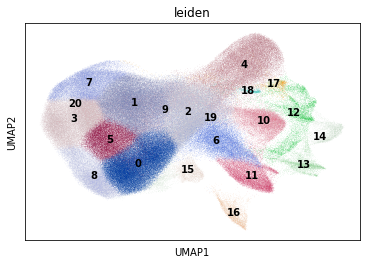

In [9]:
# dividing by volume instead
ad_viz.layers["counts"] = ad_viz.X.copy()
resolution = 1
# Leiden Clustering
######################

# dividing by volume instead
sc.pp.normalize_total(ad_viz)
sc.pp.log1p(ad_viz)
sc.pp.scale(ad_viz, max_value=10)
sc.tl.pca(ad_viz, svd_solver="arpack")
sc.pp.neighbors(ad_viz, n_neighbors=10, n_pcs=20)
sc.tl.umap(ad_viz)
sc.tl.leiden(ad_viz, resolution=resolution)

# Calculate Leiden Signatures
#########################################
ser_counts = ad_viz.obs["leiden"].value_counts()
ser_counts.name = "cell counts"
meta_leiden = pd.DataFrame(ser_counts)

cat_name = "leiden"
sig_leiden = pd.DataFrame(
    columns=ad_viz.var_names, index=ad_viz.obs[cat_name].cat.categories
)
for clust in ad_viz.obs[cat_name].cat.categories:
    sig_leiden.loc[clust] = ad_viz[ad_viz.obs[cat_name].isin([clust]), :].X.mean(0)
sig_leiden = sig_leiden.transpose()
leiden_clusters = ["Leiden-" + str(x) for x in sig_leiden.columns.tolist()]
sig_leiden.columns = leiden_clusters
meta_leiden.index = sig_leiden.columns.tolist()
meta_leiden["leiden"] = pd.Series(
    meta_leiden.index.tolist(), index=meta_leiden.index.tolist()
)

# generate colors for categories by plotting
sc.pl.umap(ad_viz, color="leiden", legend_loc="on data")
cats = ad_viz.obs["leiden"].cat.categories.tolist()
colors = list(ad_viz.uns["leiden_colors"])
cat_colors = dict(zip(cats, colors))

In [10]:
import numpy as np

gene_panel = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41421-021-00266-1/MediaObjects/41421_2021_266_MOESM1_ESM.xlsx"
meta_gene = pd.DataFrame(
    {"expression": np.asarray(ad_viz.layers["counts"].sum(axis=0)).flatten().shape},
    index=ad_viz.var_names,
)
df_ref_panel_ini = pd.read_excel(gene_panel, index_col=0)
df_ref_panel = df_ref_panel_ini.iloc[1:, :1]
df_ref_panel.index.name = None
df_ref_panel.columns = ["Function"]

marker_genes = df_ref_panel[
    df_ref_panel["Function"].str.contains("marker")
].index.tolist()
common_marker_genes = list(set(meta_gene.index.tolist()).intersection(marker_genes))
meta_gene.loc[common_marker_genes, "Markers"] = df_ref_panel.loc[
    common_marker_genes, "Function"
]
meta_gene["Markers"] = meta_gene["Markers"].apply(
    lambda x: "N.A." if "marker" not in str(x) else x
)
meta_gene["Markers"].value_counts()

N.A.                            285
HSC marker                        8
Hepatocyte marker                 5
Erythroid progenitor marker       5
Macrophage marker                 5
SEC marker                        5
Neutrophil marker                 5
MK marker                         5
Potential HSC marker              5
Pre-B cell marker                 5
Erythroid cell marker             4
EC marker                         4
AEC marker                        2
Myeloid marker                    2
Macrophage/Hepatocyte marker      1
Basophil marker                   1
Name: Markers, dtype: int64

In [11]:
from copy import deepcopy

ser_color = pd.Series(cat_colors)
ser_color.name = "color"
df_colors = pd.DataFrame(ser_color)
df_colors.index = ["Leiden-" + str(x) for x in df_colors.index.tolist()]

meta_gene["info"] = pd.Series("", index=meta_gene.index.tolist())
df_colors.loc[""] = "white"

sig_leiden_clip = deepcopy(sig_leiden)
sig_leiden_clip[sig_leiden_clip < -5] = -5
sig_leiden_clip[sig_leiden_clip >= 5] = 5

# alphabetize genes
sig_leiden_clip = sig_leiden_clip.loc[sorted(sig_leiden_clip.index.tolist())]
sig_leiden_clip.head()

meta_gene = pd.DataFrame(index=sig_leiden.index.tolist())
meta_gene["Markers"] = pd.Series("N.A.", index=sig_leiden.index.tolist())
meta_gene.loc[common_marker_genes, "Markers"] = df_ref_panel.loc[
    common_marker_genes, "Function"
]

df_colors.loc["N.A.", "color"] = "white"

In [12]:
meta_leiden["Cell_Type"] = pd.Series("N.A.", index=meta_leiden.index.tolist())
num_top_genes = 30
for inst_cluster in sig_leiden.columns.tolist():
    top_genes = (
        sig_leiden[inst_cluster]
        .sort_values(ascending=False)
        .index.tolist()[:num_top_genes]
    )

    inst_ser = meta_gene.loc[top_genes, "Markers"]
    inst_ser = inst_ser[inst_ser != "N.A."]
    ser_counts = inst_ser.value_counts()

    max_count = ser_counts.max()

    max_cat = "_".join(sorted(ser_counts[ser_counts == max_count].index.tolist()))
    max_cat = max_cat.replace(" marker", "").replace(" ", "-")

    print(inst_cluster, max_cat)
    meta_leiden.loc[inst_cluster, "Cell_Type"] = max_cat

Leiden-0 Hepatocyte
Leiden-1 Hepatocyte
Leiden-2 SEC
Leiden-3 Hepatocyte
Leiden-4 SEC
Leiden-5 Hepatocyte
Leiden-6 Macrophage
Leiden-7 Erythroid-progenitor_Pre-B-cell
Leiden-8 Hepatocyte
Leiden-9 AEC_Hepatocyte
Leiden-10 AEC_Potential-HSC
Leiden-11 Macrophage
Leiden-12 MK
Leiden-13 HSC
Leiden-14 Neutrophil
Leiden-15 Neutrophil
Leiden-16 HSC_Pre-B-cell
Leiden-17 MK_Pre-B-cell_SEC
Leiden-18 SEC
Leiden-19 Erythroid-cell_MK
Leiden-20 Pre-B-cell


In [13]:
meta_leiden

cell counts     leiden                        Cell_Type
Leiden-0         54539   Leiden-0                       Hepatocyte
Leiden-1         50485   Leiden-1                       Hepatocyte
Leiden-2         42814   Leiden-2                              SEC
Leiden-3         33945   Leiden-3                       Hepatocyte
Leiden-4         33806   Leiden-4                              SEC
Leiden-5         21760   Leiden-5                       Hepatocyte
Leiden-6         20634   Leiden-6                       Macrophage
Leiden-7         19673   Leiden-7  Erythroid-progenitor_Pre-B-cell
Leiden-8         18800   Leiden-8                       Hepatocyte
Leiden-9         15565   Leiden-9                   AEC_Hepatocyte
Leiden-10        13858  Leiden-10                AEC_Potential-HSC
Leiden-11        12696  Leiden-11                       Macrophage
Leiden-12         8438  Leiden-12                               MK
Leiden-13         4909  Leiden-13                              HSC
Leiden-14         4743  Leiden-14                       Neutrophil
Leiden-15         3830  Leiden-15                       Neutrophil
Leiden-16         3440  Leiden-16                   HSC_Pre-B-cell
Leiden-17         1736  Leiden-17                MK_Pre-B-cell_SEC
Leiden-18          927  Leiden-18                              SEC
Leiden-19          324  Leiden-19                Erythroid-cell_MK
Leiden-20          313  Leiden-20                       Pre-B-cell

In [14]:
ad_viz.obs["leiden_map"] = pd.Categorical(
    ["Leiden-" + str(x) for x in ad_viz.obs["leiden"]]
)

In [15]:
ad_viz.obs["leiden_map"].replace(
    {k: v for k, v in zip(meta_leiden["leiden"], meta_leiden["Cell_Type"])},
    inplace=True,
)

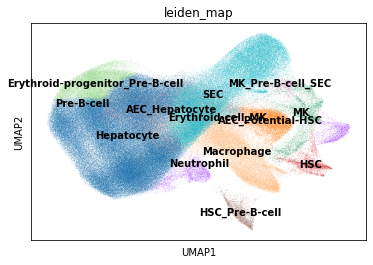

In [16]:
sc.pl.umap(ad_viz, color="leiden_map", legend_loc="on data")

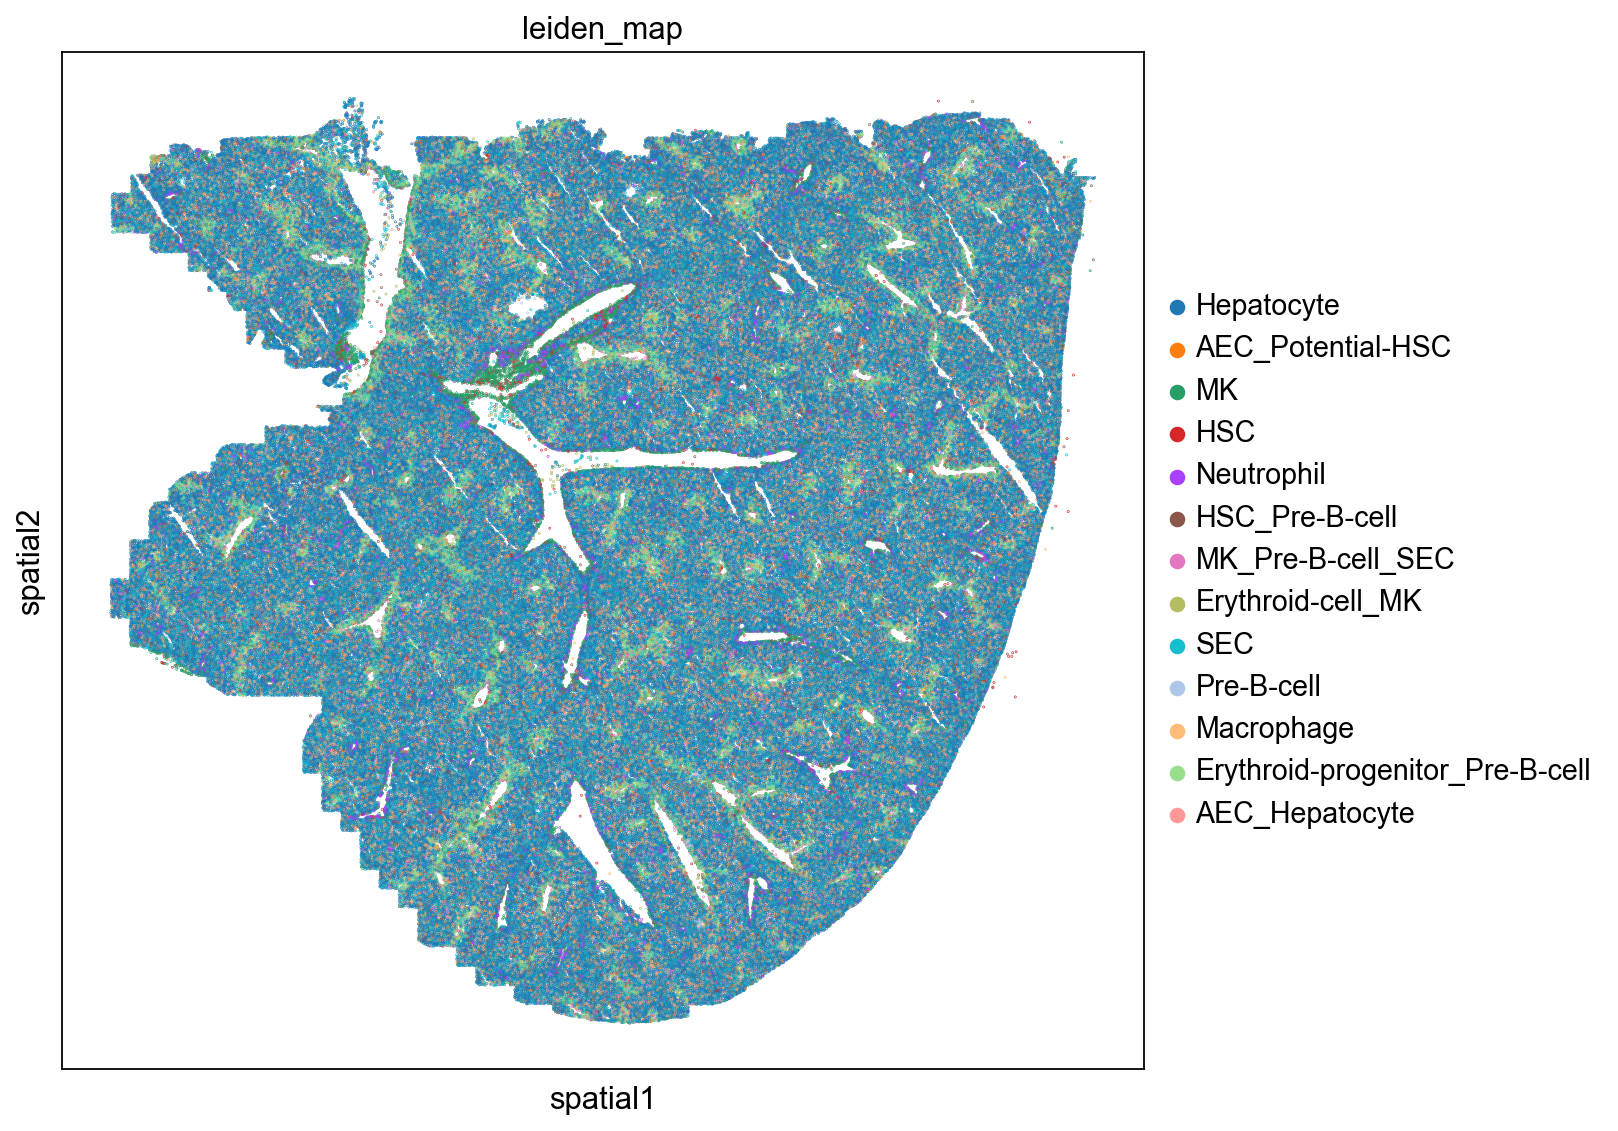

In [18]:
sc.set_figure_params(figsize=(10, 10))
sq.pl.spatial_scatter(ad_viz, shape=None, color="leiden_map", size=0.1)

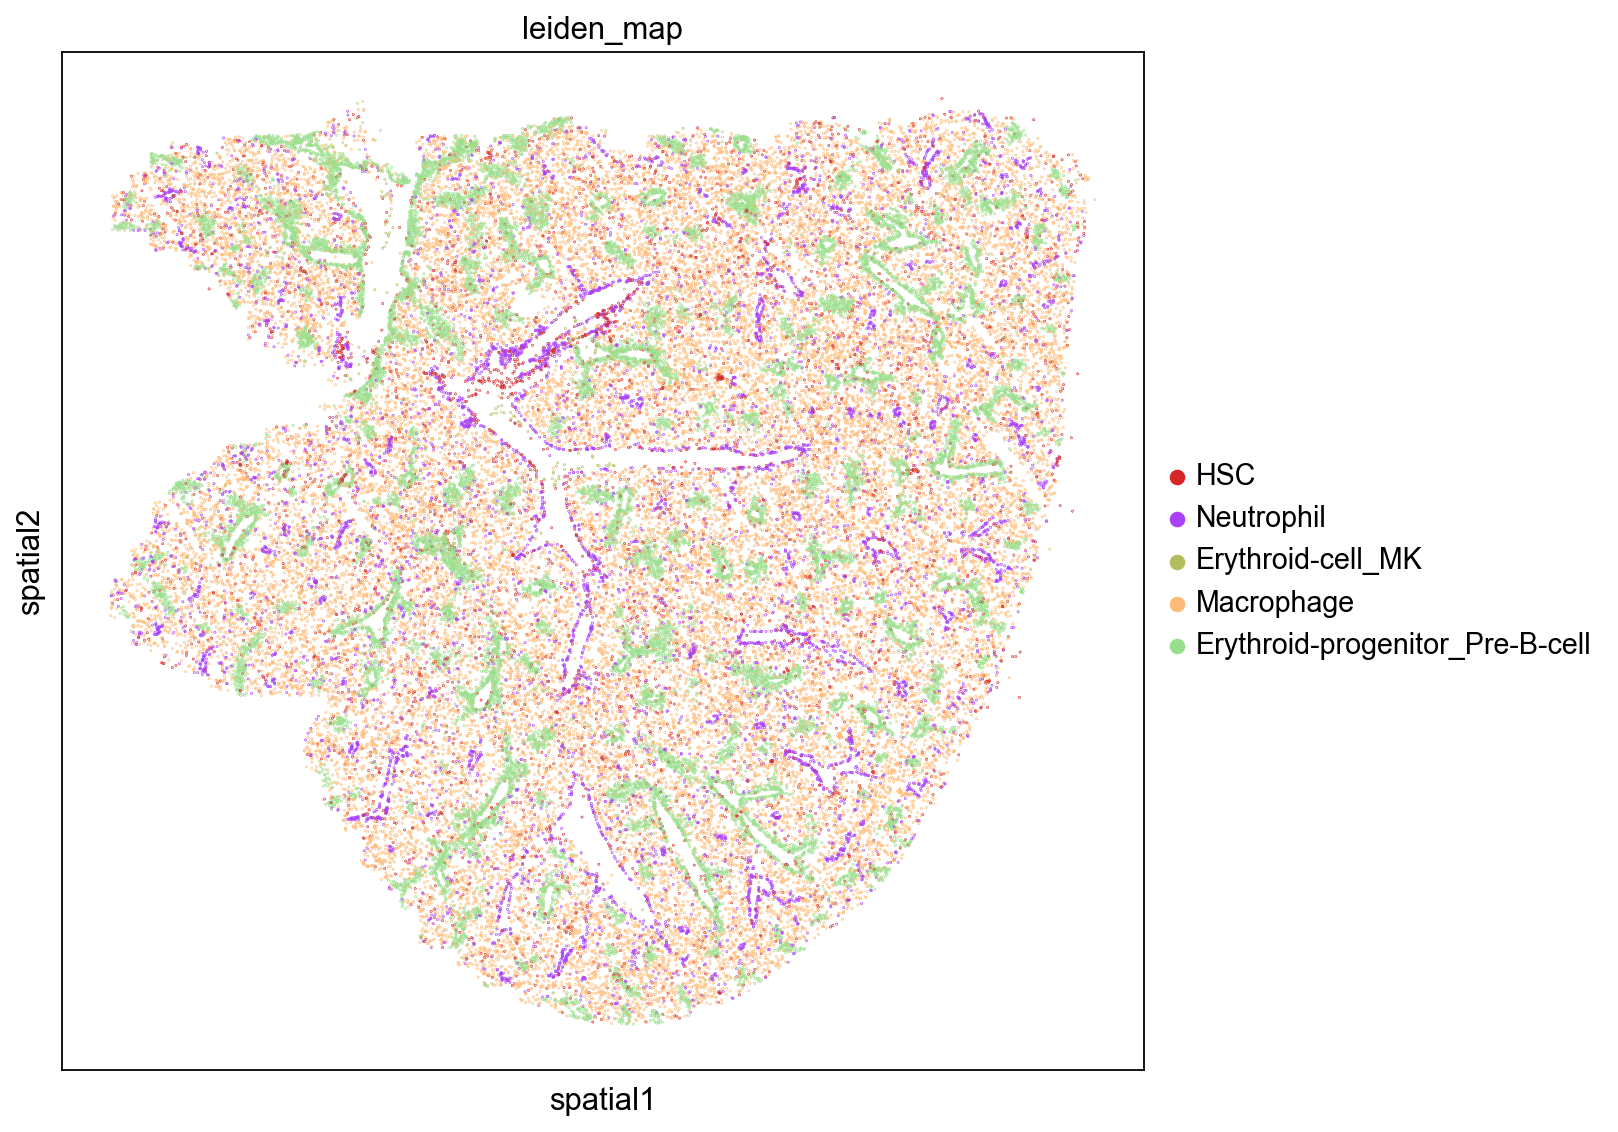

In [22]:
sq.pl.spatial_scatter(
    ad_viz,
    shape=None,
    color="leiden_map",
    groups=[
        "Erythroid-cell_MK",
        "Erythroid-progenitor_Pre-B-cell",
        "Neutrophil",
        "Macrophage",
        "HSC",
    ],
    size=0.1,
)

In [23]:
path = pathlib.Path("/Users/giovanni.palla/Datasets/vizgen_merfish")
ad_viz.write(path / "adata_result.h5ad")